# Expedia Hotel Recommendations

#### Which hotel type will an Expedia customer book?

### Importing Libraries

In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from surprise import SVD, accuracy
from surprise import Dataset, Reader, KNNBaseline, SVD, NMF, CoClustering
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

### Reading training data (train.csv)

In [37]:
train_data = pd.read_csv("./dataset/train.csv", sep = ",", nrows = 100000)
#train_data = pd.read_csv("train.csv", sep = ",")

### Getting familiar with the data and Exploratory Data Analysis

In [38]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [39]:
train_data.shape

(100000, 24)

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

In [41]:
train_data.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,63078.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,9.10014,2.637850,84.531040,311.630930,28465.223540,1897.609161,195700.878390,0.138030,0.260470,5.760540,...,0.325160,1.112700,14511.034340,2.590540,0.08270,1.477770,3.206530,80.972620,597.559610,49.74576
std,12.09091,0.751001,54.320574,209.399151,16822.922817,2123.885180,110173.879786,0.344933,0.438893,3.771156,...,0.722341,0.441928,11043.082364,2.160456,0.27543,1.197163,1.624119,55.679861,507.624672,28.95063
min,2.00000,0.000000,0.000000,0.000000,3.000000,0.005600,12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,2.00000,3.000000,66.000000,174.000000,13914.000000,290.528875,107548.000000,0.000000,0.000000,2.000000,...,0.000000,1.000000,8267.000000,1.000000,0.00000,1.000000,2.000000,50.000000,160.000000,25.00000
50%,2.00000,3.000000,66.000000,311.000000,27733.000000,1093.888450,181983.000000,0.000000,0.000000,9.000000,...,0.000000,1.000000,11271.000000,1.000000,0.00000,1.000000,2.000000,50.000000,585.000000,49.00000
75%,11.00000,3.000000,69.000000,385.000000,43113.000000,2518.177400,301357.000000,0.000000,1.000000,9.000000,...,0.000000,1.000000,18881.000000,5.000000,0.00000,2.000000,4.000000,106.000000,701.000000,73.00000
max,53.00000,4.000000,239.000000,1025.000000,56495.000000,11641.224200,391007.000000,1.000000,1.000000,10.000000,...,9.000000,8.000000,65035.000000,9.000000,1.00000,59.000000,6.000000,212.000000,2117.000000,99.00000


## Importing Destination data

In [42]:
destination_data = pd.read_csv("./dataset/destinations.csv", sep=',')

In [43]:
destination_data.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


### Applying PCA to get 10 most relevant dimensions

In [44]:
model = PCA(n_components=None).fit(destination_data)
destination_data_pc = model.transform(destination_data)
destination_data_pc

array([[-3.23594639e+04,  3.91171508e-02,  1.83897680e-01, ...,
        -8.95076187e-04,  2.72242521e-05, -1.38904284e-06],
       [-3.23584639e+04, -3.56569311e-01,  9.17178951e-02, ...,
         1.90740877e-04, -2.29089126e-04,  8.45786956e-05],
       [-3.23574639e+04,  8.63287331e-02,  3.66722352e-02, ...,
        -2.13700576e-03,  1.87017759e-03, -2.20432977e-04],
       ...,
       [ 3.26315361e+04,  8.05617083e-02,  1.92824073e-01, ...,
        -5.68538143e-04, -1.21487882e-04,  1.58066944e-04],
       [ 3.26325361e+04, -6.66110376e-01, -4.38087800e-02, ...,
        -4.00914640e-05,  2.20538540e-04, -1.60722688e-05],
       [ 3.26335361e+04, -4.61482798e-01, -2.75790500e-02, ...,
        -4.96164892e-04, -1.61638319e-04,  3.60342984e-05]])

In [45]:
number_features= model.components_.shape[0]
number_features

150

### Most important feature index on each component

In [46]:
most_related_column = [np.abs(model.components_[i]).argmax() for i in range(number_features)]
print(most_related_column)

[0, 37, 9, 58, 108, 6, 108, 20, 108, 88, 6, 20, 71, 94, 71, 53, 6, 66, 53, 43, 136, 103, 103, 53, 14, 77, 136, 141, 114, 132, 55, 136, 55, 44, 13, 44, 122, 122, 11, 110, 11, 83, 76, 21, 17, 78, 146, 17, 129, 137, 126, 126, 75, 126, 129, 34, 34, 10, 142, 47, 47, 22, 102, 2, 25, 96, 35, 4, 35, 36, 61, 61, 30, 73, 36, 1, 109, 96, 127, 50, 1, 98, 127, 134, 30, 82, 48, 32, 69, 81, 105, 81, 81, 85, 59, 68, 32, 8, 38, 143, 42, 62, 39, 62, 54, 144, 124, 26, 104, 67, 89, 120, 125, 107, 100, 46, 19, 3, 145, 133, 63, 64, 63, 28, 95, 111, 95, 148, 117, 97, 52, 31, 40, 118, 12, 140, 86, 119, 86, 60, 90, 113, 70, 15, 23, 116, 123, 72, 72, 135]


In [47]:
initial_column= ['srch_destination_id', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'd41', 'd42', 'd43', 'd44', 'd45', 'd46', 'd47', 'd48', 'd49', 'd50', 'd51', 'd52', 'd53', 'd54', 'd55', 'd56', 'd57', 'd58', 'd59', 'd60', 'd61', 'd62', 'd63', 'd64', 'd65', 'd66', 'd67', 'd68', 'd69', 'd70', 'd71', 'd72', 'd73', 'd74', 'd75', 'd76', 'd77', 'd78', 'd79', 'd80', 'd81', 'd82', 'd83', 'd84', 'd85', 'd86', 'd87', 'd88', 'd89', 'd90', 'd91', 'd92', 'd93', 'd94', 'd95', 'd96', 'd97', 'd98', 'd99','d100','d101','d102','d103','d104','d105','d106', 'd107','d108','d109','d110','d111','d112','d113','d114','d115', 'd116','d117','d118','d119','d120','d121','d122','d123','d124','d125','d126','d127','d128','d129','d130','d131','d132','d133','d134','d135','d136','d137','d138','d139','d140','d141','d142','d143', 'd144','d145','d146','d147','d148','d149']

### Get the names of most important features

In [48]:
most_relevant_column_names = [initial_column[most_related_column[i]] for i in range(number_features)]

In [49]:
dic = {'PC{}'.format(i): most_relevant_column_names[i] for i in range(number_features)}

### Building Dataframe

In [50]:
relevant_column = pd.DataFrame(dic.items())

In [51]:
relevant_column.head(20)

,0,1
0,PC0,srch_destination_id
1,PC1,d37
2,PC2,d9
3,PC3,d58
4,PC4,d108
5,PC5,d6
6,PC6,d108
7,PC7,d20
8,PC8,d108
9,PC9,d88


### Merging top 10 most important and correlated columns

In [52]:
train_data = pd.merge(train_data,destination_data[['srch_destination_id','d37', 'd9', 'd58', 'd108', 'd6', 'd108', 'd20', 'd108', 'd88', 'd71']],on='srch_destination_id')

### Correlation Matrix

In [53]:
train_data_copy = train_data.copy()
train_data_copy.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'd37', 'd9', 'd58', 'd108', 'd6', 'd108', 'd20',
       'd108', 'd88', 'd71'],
      dtype='object')

In [54]:
train_data_copy= train_data_copy.drop(['d37'],axis=1)
train_data_copy= train_data_copy.drop(['d9'],axis=1)
train_data_copy= train_data_copy.drop(['d58'],axis=1)
train_data_copy= train_data_copy.drop(['d108'],axis=1)
train_data_copy= train_data_copy.drop(['d6'],axis=1)
train_data_copy= train_data_copy.drop(['d20'],axis=1)
train_data_copy= train_data_copy.drop(['d88'],axis=1)
train_data_copy= train_data_copy.drop(['d71'],axis=1)

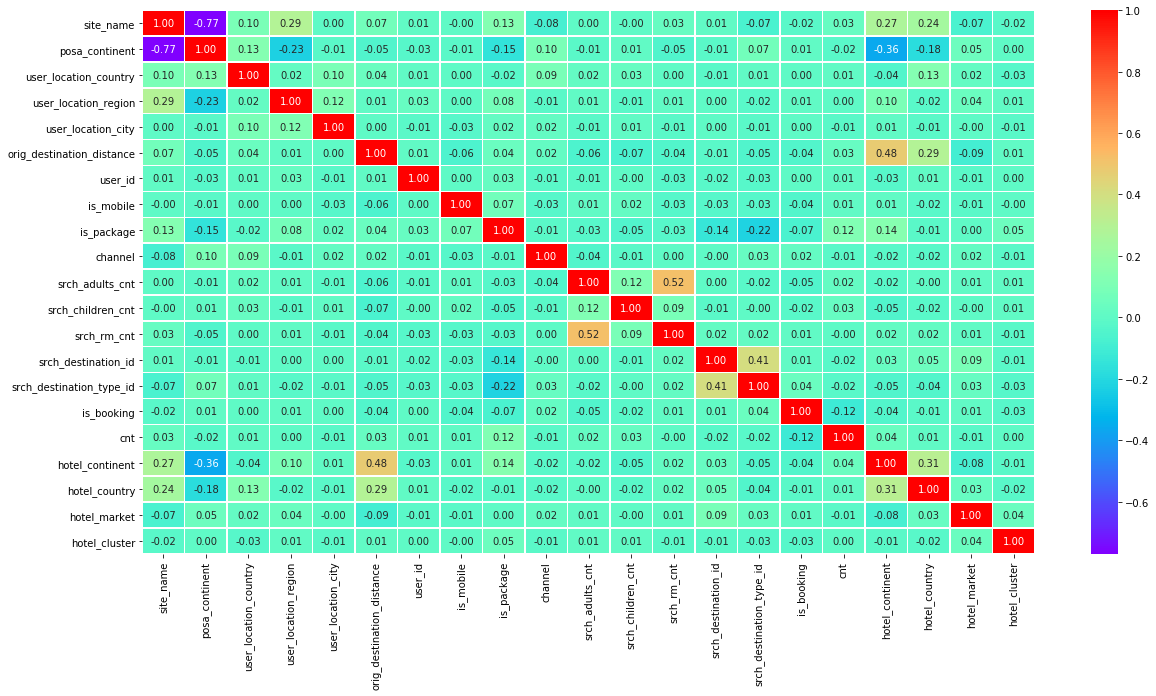

In [55]:
corr = train_data_copy.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(round(corr, 2).iloc[:, :], annot=True, linewidths=.5, ax=ax, cmap="rainbow",fmt='.2f')

### Most number of hotels in the Country

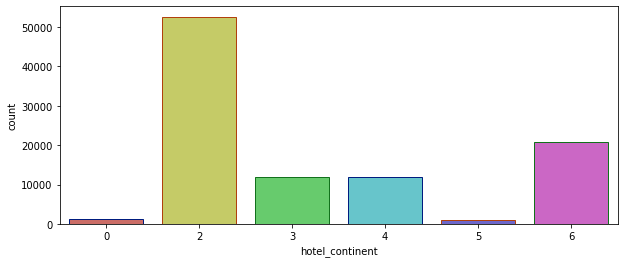

In [56]:
plt.figure(figsize=(10, 4))
sns.countplot(x='hotel_continent', palette='hls',data=train_data, edgecolor=sns.color_palette("dark", 3))

### User Location Country

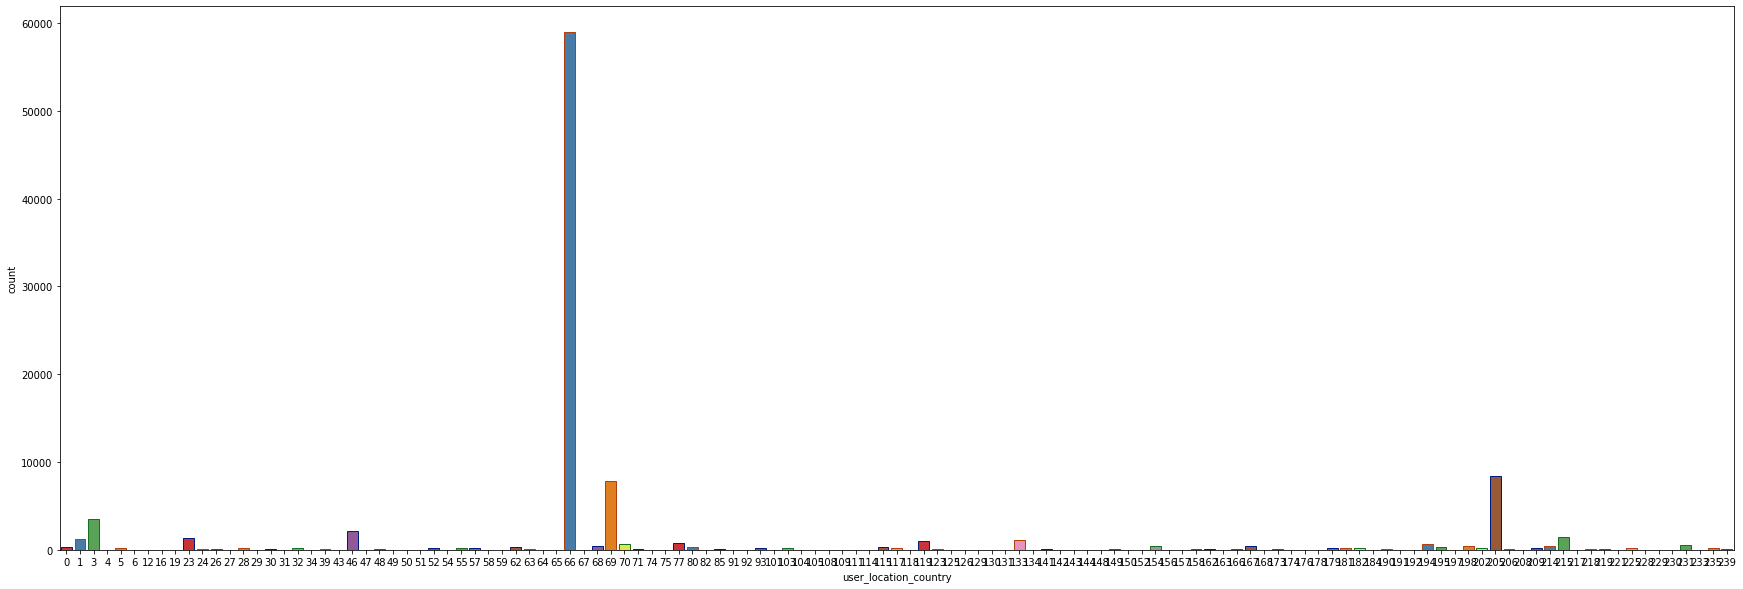

In [57]:
plt.figure(figsize=(30, 10))
sns.countplot(x=train_data['user_location_country'],palette="Set1", edgecolor=sns.color_palette("dark", 3))

### Top 10 User Countries

In [58]:
top_ten_user_countries = train_data.groupby('user_location_country')['user_location_region'].count().sort_values(ascending=False)[:10]

In [59]:
top_ten_user_countries

user_location_country
66     58956
205     8363
69      7895
3       3535
46      2195
215     1428
23      1331
1       1185
133     1155
119      969
Name: user_location_region, dtype: int64

### Total Number of Bookings over Date

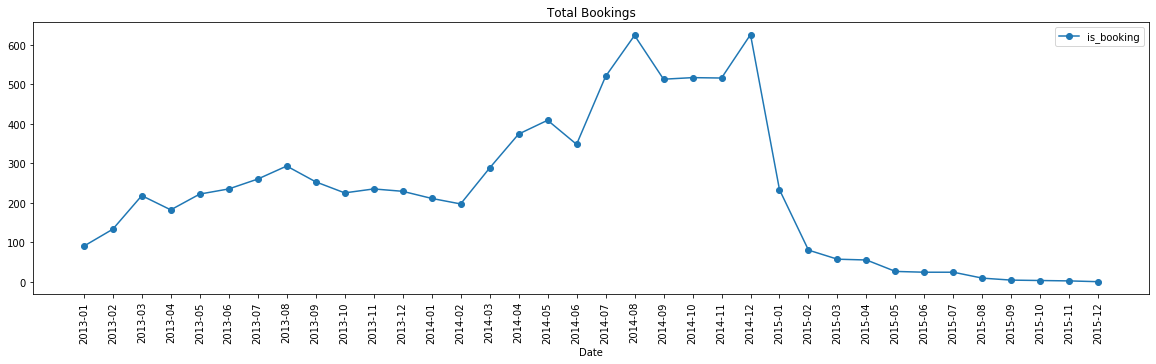

In [60]:
train_data['Date']  = train_data['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)
date_bookings  = train_data.groupby('Date')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(20,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

### Creating a new dataframe with user_id, hotel_cluster and is_booking fields

In [61]:
new_df = train_data[['user_id', 'hotel_cluster', 'is_booking']]

In [62]:
new_df.head()

,user_id,hotel_cluster,is_booking
0,12,1,0
1,12,1,1
2,12,1,0
3,776,24,0
4,3313,45,0


In [63]:
new_df.columns = ['user_id', 'hotel_id', 'booking']
new_df = new_df.sort_values(['user_id', 'hotel_id'])
new_df = new_df.reset_index().drop('index', axis = 1)
new_df.head()

,user_id,hotel_id,booking
0,12,1,0
1,12,1,1
2,12,1,0
3,93,21,0
4,93,80,0


In [64]:
booked_hotels = new_df.groupby(['user_id', 'hotel_id']).booking.transform(max)
new_df = new_df.loc[new_df.booking == booked_hotels]
new_df.drop_duplicates(keep = 'first', inplace = True)
new_df= new_df.reset_index().drop('index', axis = 1)
new_df

,user_id,hotel_id,booking
0,12,1,1
1,93,21,0
2,93,80,0
3,93,92,0
4,501,10,0
...,...,...,...
40643,391007,81,0
40644,391007,85,0
40645,391007,90,0
40646,391007,93,0


### Calculated each of the hotel cluster's mean to find similar hotel clusters

In [65]:
bookings = pd.DataFrame(new_df.groupby(['hotel_id'])['booking'].mean())
bookings

,booking
hotel_id,
0,0.117794
1,0.253205
2,0.207469
3,0.113372
4,0.184855
...,...
95,0.230104
96,0.076212
97,0.149474


In [66]:
bookings_matrix = new_df.pivot_table(index = 'user_id', columns = 'hotel_id', values = 'booking')
bookings_matrix.head()

hotel_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
756,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
bookings_matrix = bookings_matrix.fillna(0)
bookings_matrix

hotel_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding similar hotel clusters

In [69]:
def find_similar_hotel_clusters(hotel_cluster): 
    item_user_bookings = bookings_matrix[hotel_cluster]
    hotel_correlation = bookings_matrix.corrwith(item_user_bookings)
    corr_clusterid = pd.DataFrame(hotel_correlation, columns=['correlation_value'])
    corr_clusterid.loc[~(corr_clusterid==0).all(axis=1)]
    corr_clusterid = corr_clusterid.round({'correlation_value': 2})
    return corr_clusterid.sort_values('correlation_value',ascending=False).head(n = 5)

In [70]:
find_similar_hotel_clusters(65)

,correlation_value
hotel_id,
65,1.00
56,0.08
66,0.06
23,0.05
1,0.05


### What are we predicting?

#### The objective is to predict which hotel_cluster a user will book given the information in their search. There are 100 clusters in total.

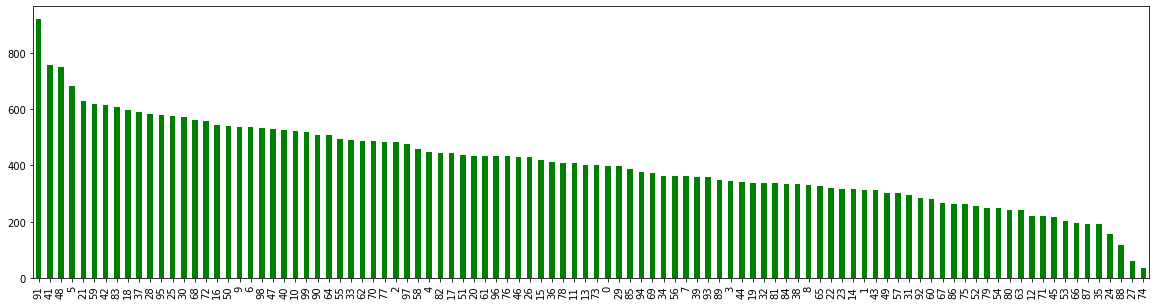

In [71]:
new_df['hotel_id'].value_counts().plot(kind='bar',color="green",figsize=(20,5))

## Collaborative Filtering using Cosine Similarity

In [72]:
users_count, hotels_count = new_df.user_id.unique().shape[0], new_df.hotel_id.unique().shape[0]

In [73]:
print("The no of unique users = ",users_count)
print("The no of hotel clusters = ",hotels_count)

The no of unique users =  3472
The no of hotel clusters =  100


In [74]:
def map_ids_to_idx(df):
    user_idx = np.arange(0, users_count)
    hotel_idx = np.arange(0, hotels_count)
    
    idx_user_df = pd.DataFrame(df.user_id.unique(), columns=["user"])
    idx_user_df["idx"] = user_idx
    
    idx_hotel_df = pd.DataFrame(df.hotel_id.unique(), columns=["hotel"])
    idx_hotel_df["idx"] = hotel_idx
    
    df["hotel_index"] = df["hotel_id"].map(idx_hotel_df.set_index('hotel')["idx"]).fillna(0)
    df["user_index"] = df["user_id"].map(idx_user_df.set_index('user')["idx"]).fillna(0)

    return df

In [75]:
new_df = map_ids_to_idx(new_df)
new_df

,user_id,hotel_id,booking,hotel_index,user_index
0,12,1,1,0,0
1,93,21,0,1,1
2,93,80,0,2,1
3,93,92,0,3,1
4,501,10,0,4,2
...,...,...,...,...,...
40643,391007,81,0,29,3471
40644,391007,85,0,31,3471
40645,391007,90,0,59,3471
40646,391007,93,0,86,3471


### Splitting the data into training and testing

In [76]:
train_data, test_data = train_test_split(new_df, test_size = 0.3)

In [77]:
utility_matrix = np.zeros((users_count, hotels_count))
for row in new_df.itertuples():
    utility_matrix[row[5], row[4]] = row[3]
utility_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Creating utility matrix for training data and testing data

In [78]:
train_utility_matrix = np.zeros((users_count, hotels_count))
for row in train_data.itertuples():
    train_utility_matrix[row[5], row[4]] = row[3]
train_utility_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
test_utility_matrix = np.zeros((users_count, hotels_count))
for row in test_data.itertuples():
    test_utility_matrix[row[5], row[4]] = row[3]
test_utility_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Calculating the cosine similarity

In [80]:
similarity_btw_users = pairwise_distances(train_utility_matrix, metric = 'cosine')
similarity_btw_users

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [81]:
transpose_utility_matrix = train_utility_matrix.T
similarity_btw_items = pairwise_distances(transpose_utility_matrix, metric = 'cosine')
similarity_btw_items

array([[0.        , 0.96674969, 1.        , ..., 1.        , 0.94197411,
        1.        ],
       [0.96674969, 0.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        0.7763932 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.94197411, 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 1.        , 0.7763932 , ..., 1.        , 1.        ,
        0.        ]])

### Performing predictions based on cosine similarity

In [82]:
def user_prediction(matrix, similarity_measure):
    avg_user_booking = matrix.mean(axis = 1)
    diff_of_bookings = (matrix - avg_user_booking[:, np.newaxis])
    pred = avg_user_booking[:, np.newaxis] + similarity_measure.dot(diff_of_bookings) / np.array([np.abs(similarity_measure).sum(axis=1)]).T
    return pred

In [83]:
user_pred = user_prediction(train_utility_matrix, similarity_btw_users)

In [84]:
user_pred

array([[ 1.81368261e-03,  1.64463076e-02,  3.30090232e-05, ...,
        -2.58775350e-03,  3.30504811e-03, -2.29655767e-03],
       [ 2.54681648e-03,  6.29213483e-03, -1.01296456e-02, ...,
        -1.27225583e-02, -6.67242869e-03, -1.24344569e-02],
       [ 2.54681648e-03,  6.29213483e-03, -1.01296456e-02, ...,
        -1.27225583e-02, -6.67242869e-03, -1.24344569e-02],
       ...,
       [ 2.28111743e-02,  2.65358708e-02,  1.00419516e-02, ...,
         7.50038354e-03,  1.36001469e-02,  7.71823223e-03],
       [ 1.26566555e-02,  1.66137413e-02,  1.52424017e-04, ...,
        -2.47648999e-03,  3.65764270e-03, -2.18438844e-03],
       [ 1.27385817e-02,  1.60095311e-02,  2.40765256e-04, ...,
        -2.39282799e-03,  3.75222292e-03, -2.10020652e-03]])

In [85]:
def item_prediction(matrix, similarity_measure):
    pred = matrix.dot(similarity_measure) / np.array([np.abs(similarity_measure).sum(axis=1)])
    return pred

In [86]:
item_pred = item_prediction(train_utility_matrix, similarity_btw_items)

In [87]:
item_pred.shape

(3472, 100)

In [88]:
def rmse_value(predicted, test):
    predicted = predicted[test.nonzero()].flatten()
    test = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predicted, test))

def mae_value(predicted, test):
    predicted = predicted[test.nonzero()].flatten()
    test = test[test.nonzero()].flatten()
    return sqrt(mean_absolute_error(predicted, test))

#### The RMSE and MAE of user based CF 

In [89]:
print("RMSE = ", rmse_value(user_pred, test_utility_matrix))
print("MAE = ", mae_value(user_pred, test_utility_matrix))

RMSE =  0.9613948582079813
MAE =  0.9800277430786525


#### The RMSE and MAE of item based CF

In [90]:
print("RMSE = ", rmse_value(item_pred, test_utility_matrix))
print("MAE = ", mae_value(item_pred, test_utility_matrix))

RMSE =  0.9659289068155998
MAE =  0.9823591165906185


In [95]:
reader = Reader()
bookings_data = Dataset.load_from_df(new_df[['user_id', 'hotel_id', 'booking']], reader)

In [96]:
algorithm_1 = KNNBaseline()
res_1 = cross_validate(algorithm_1, bookings_data, measures=['RMSE', 'MAE'], cv = 5, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9186  0.9156  0.9164  0.9173  0.9168  0.9169  0.0010  
MAE (testset)     0.8439  0.8383  0.8399  0.8414  0.8404  0.8408  0.0019  
Fit time          1.54    1.66    1.51    1.33    1.35    1.48    0.12    
Test time         3.80    5.06    4.46    4.64    4.72    4.53    0.41    


In [97]:
algorithm_2 = SVD()
res_2 = cross_validate(algorithm_2, bookings_data, measures=['RMSE', 'MAE'], cv = 5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9186  0.9186  0.9146  0.9162  0.9168  0.9169  0.0015  
MAE (testset)     0.8438  0.8438  0.8364  0.8393  0.8406  0.8408  0.0028  
Fit time          3.05    3.39    3.96    3.47    2.61    3.30    0.45    
Test time         0.22    0.14    0.08    0.17    0.08    0.14    0.05    


In [98]:
algorithm_3 = CoClustering()
res_3 = cross_validate(algorithm_3, bookings_data, measures=['RMSE', 'MAE'], cv = 5, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9150  0.9194  0.9150  0.9193  0.9172  0.9172  0.0020  
MAE (testset)     0.8372  0.8452  0.8371  0.8450  0.8411  0.8411  0.0036  
Fit time          2.31    1.62    1.52    1.61    1.44    1.70    0.31    
Test time         0.22    0.06    0.05    0.16    0.05    0.11    0.07    


In [99]:
def avg_rmse(result):
    return sum(result['test_rmse']) / 5

In [100]:
avg_rmse(res_1)

0.9169396581792071

In [101]:
avg_rmse(res_2)

0.9169389258175091

In [102]:
avg_rmse(res_3)

0.9171983200351537

In [103]:
param_grid = {'n_epochs': [5, 10, 30], 'lr_all': [0.002, 0.006],
              'reg_all': [0.05, 0.4, 0.6], 'n_factors' : [10, 20, 30]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(bookings_data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9169378033940656
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.05, 'n_factors': 10}


In [104]:
train_bookings_data, test_bookings_data = train_test_split(bookings_data, test_size = 0.3)

In [105]:
svd_algo = SVD(n_factors = 10, n_epochs = 5, lr_all = 0.002, reg_all = 0.05)
svd_algo.fit(train_bookings_data)

In [108]:
predictions = svd_algo.test(test_bookings_data)
print("Accuracy = ",accuracy.rmse(predictions))

RMSE: 0.9195
Accuracy =  0.9195164245974897


In [109]:
predictions[0:5]

[Prediction(uid=164202, iid=72, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=85275, iid=37, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=222772, iid=62, r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid=367735, iid=4, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=349183, iid=21, r_ui=0.0, est=1, details={'was_impossible': False})]

In [111]:
test_bookings = []
for pred in predictions:
    test_bookings.append(pred[3])

In [112]:
final_test_bookings = pd.DataFrame(predictions)

In [113]:
final_test_bookings =final_test_bookings.drop(columns= ['r_ui', 'details'])

In [114]:
final_test_bookings.columns = ['user_id', 'hotel_id', 'is_booking']

In [115]:
final_test_bookings.head()

,user_id,hotel_id,is_booking
0,164202,72,1
1,85275,37,1
2,222772,62,1
3,367735,4,1
4,349183,21,1
